## Finetuning pre-trained in a self-supervised manner ViT transformer on LIDC dataset.

In [2]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import pickle
import torch
from torchvision import transforms
from lightning import Trainer
import lightning as L
import numpy as np
from typing import Optional, Dict
from prettytable import PrettyTable

In [4]:
%load_ext autoreload
%autoreload 2
    
from my_utils.plot_utils import plot_hists
from my_utils.norm_factors import compute_norm_factors
from End2End_Model import End2End_Model
from LIDC_DataModule import DataModule

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Dividing dataset into three sets: training, validation and test sets.

In [5]:
# Paths
local = False
if local:
    datapath = "/home/jbinda/INFORM/LIDC/dataset/"
    subsets_saving_path = "/home/jbinda/INFORM/LIDC_ViTs/dataset/splitted_sets/"
    checkpoints_path="/home/jbinda/INFORM/LIDC_ViTs/ckpt/End2End/"
    Path(subsets_saving_path).mkdir(parents=True, exist_ok=True)
else:
    datapath = "/home/dzban112/LIDC_ViTs/dataset/"
    subsets_saving_path = "/home/dzban112/LIDC_ViTs/dataset/splitted_sets/"
    checkpoints_path="/home/dzban112/LIDC_ViTs/ckpt/End2End/"
    Path(subsets_saving_path).mkdir(parents=True, exist_ok=True)

In [6]:
#Reading all annotations and extracting paths, target: benign, malignant.
df = pd.read_pickle(f"{datapath}/ALL_annotations_df.pkl")

In [7]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=44)
folds = skf.split(X=df["path"], y=df["target"])

In [8]:
for i, (train_indices, test_indices) in enumerate(folds):
    with open(subsets_saving_path+f"train_fold_{i+1}.pkl", 'wb') as file:
        pickle.dump(list(train_indices), file)
    with open(subsets_saving_path+f"test_fold_{i+1}.pkl", 'wb') as file:
        pickle.dump(list(test_indices), file)

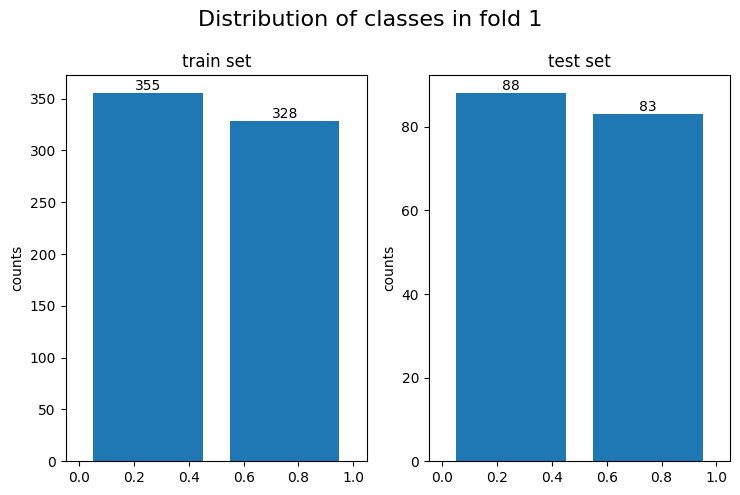

In [9]:
plot_hists(fold=1, datapath=datapath, subsets_saving_path=subsets_saving_path)

### Computing Normalization Factors

In [11]:
def prepare_norm_factors(n_splits=5):
    df = pd.read_pickle(f"{datapath}/ALL_annotations_df.pkl")
    fitted_factors = {}
    for fold in range(1, n_splits+1):
        # Computing mean and std of image pixels values.
        with open(datapath+f"/splitted_sets/train_fold_{fold}.pkl", 'rb') as file:
            train_indices = pickle.load(file)
            X_train = df.iloc[train_indices]["path"]
            mean, std = compute_norm_factors(X_train, datapath)
            
            # Creating instance of biomarker scaler
            biomarkers = df.iloc[train_indices][["subtlety", "calcification",
                                                 "margin", "lobulation",
                                                 "spiculation", "diameter",
                                                 "texture", "sphericity"]].to_numpy() #without targets
            scaler = StandardScaler().fit(biomarkers)

            # Saving in dictionary object:
            fitted_factors[f"fold_{fold}"] = (mean, std, scaler)
        

    with open(subsets_saving_path+"/"+"fitted_factors.pkl", 'wb') as f:
        pickle.dump(fitted_factors, f)
    
    return fitted_factors

fitted_factors = prepare_norm_factors(n_splits=5)

print(fitted_factors["fold_1"][0:2])
print(fitted_factors["fold_2"][0:2])
print(fitted_factors["fold_3"][0:2])
print(fitted_factors["fold_4"][0:2])
print(fitted_factors["fold_5"][0:2])

(tensor(-625.8784), tensor(363.2248))
(tensor(-631.0611), tensor(357.2651))
(tensor(-629.7866), tensor(362.4995))
(tensor(-633.4309), tensor(356.7941))
(tensor(-632.3697), tensor(356.8558))


## Finetuning End2End Model

Finetuning was performed with GPU accelaration. To train model I have used python script `train_End2End.py`.
Using first fold I have searched for the best hyperparameters and hyperparameters yielding the best model, were used to train model on five folds.

## End2End model evaluation on the test set

In [4]:
def E2E_model_evaluation(model_name:str, version:Optional[str]=None):
    res={}
    for fold in range(1,6):
        print(f"fold: {fold}")
        dm = DataModule(
            fold=fold,
            datapath=datapath,
            batch_size=16,
            num_workers=8,
            task="Classification")

        if version is None:
            ckpt_path = checkpoints_path+model_name+f"_{fold}"+".ckpt"
        else:
            ckpt_path = checkpoints_path+model_name+f"_{fold}"+f"-{version}"+".ckpt"
        model = End2End_Model.load_from_checkpoint(ckpt_path)
        torch.set_float32_matmul_precision('medium')
        trainer = pl.Trainer(accelerator="gpu", devices=1, precision=32)
        model.eval()
        res[f"fold_{fold}"] = trainer.test(model, dm)
    return res


def compute_results(raw_results:Dict[str, list]):
    ACC = []
    folds = []
    mean_ACC = 0
    n = 0
    for fold in raw_results.keys():
        cur_ACC = raw_results[fold][0]["test_acc"]
        ACC.append(cur_ACC)
        folds.append(f"Fold {fold}")
        mean_ACC += cur_ACC
        n += 1
    mean_ACC = mean_ACC/n

    df = pd.DataFrame({"Fold": folds, "Accuracy": ACC})
    df.loc[len(df)] = ['Mean Accuracy', mean_ACC]
    
    table = PrettyTable()
    table.field_names = df.columns.tolist()

    for row in df.itertuples(index=False):
        table.add_row(row)

    # Optionally, align columns
    for field in df.columns:
        table.align[field] = 'l'  # 'l' for left align, 'r' for right alig
    
    return table

#### DINO_vits16

In [ ]:
# dino_vits16_30 - version 0
res = E2E_model_evaluation(model_name="dino_vits16_30")

In [36]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.8421052694320679 |
| Fold fold_2   | 0.8830409646034241 |
| Fold fold_3   | 0.8245614171028137 |
| Fold fold_4   | 0.8187134265899658 |
| Fold fold_5   | 0.8764705657958984 |
| Mean Accuracy | 0.848978328704834  |
+---------------+--------------------+


In [ ]:
# dino_vits16_30 - version v1
res = E2E_model_evaluation(model_name="dino_vits16_30", version="v1")

In [39]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.8421052694320679 |
| Fold fold_2   | 0.8538011908531189 |
| Fold fold_3   | 0.8421052694320679 |
| Fold fold_4   | 0.8830409646034241 |
| Fold fold_5   | 0.8588235378265381 |
| Mean Accuracy | 0.8559752464294433 |
+---------------+--------------------+


In [ ]:
# dino_vits16_30 - version v2
res = E2E_model_evaluation(model_name="dino_vits16_30", version="v2")

In [43]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.8245614171028137 |
| Fold fold_2   | 0.8421052694320679 |
| Fold fold_3   | 0.8421052694320679 |
| Fold fold_4   | 0.8538011908531189 |
| Fold fold_5   | 0.8823529481887817 |
| Mean Accuracy | 0.84898521900177   |
+---------------+--------------------+


#### DINO_vitb16

In [ ]:
# dino_vitb16_31 - version 0
res = E2E_model_evaluation(model_name="dino_vitb16_31")

In [54]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.9005848169326782 |
| Fold fold_2   | 0.8538011908531189 |
| Fold fold_3   | 0.8421052694320679 |
| Fold fold_4   | 0.8888888955116272 |
| Fold fold_5   | 0.8764705657958984 |
| Mean Accuracy | 0.8723701477050781 |
+---------------+--------------------+


In [ ]:
# dino_vitb16_31 - version v1
res = E2E_model_evaluation(model_name="dino_vitb16_31", version="v1")

In [56]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.8947368264198303 |
| Fold fold_2   | 0.871345043182373  |
| Fold fold_3   | 0.8538011908531189 |
| Fold fold_4   | 0.8888888955116272 |
| Fold fold_5   | 0.8941176533699036 |
| Mean Accuracy | 0.8805779218673706 |
+---------------+--------------------+


In [ ]:
# dino_vitb16_31 - version v2
res = E2E_model_evaluation(model_name="dino_vitb16_31", version="v2")

In [58]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.8947368264198303 |
| Fold fold_2   | 0.8654970526695251 |
| Fold fold_3   | 0.847953200340271  |
| Fold fold_4   | 0.8830409646034241 |
| Fold fold_5   | 0.8823529481887817 |
| Mean Accuracy | 0.8747161984443664 |
+---------------+--------------------+


#### SL ViTb16

In [23]:
# vitb16_31 - version 0
res = E2E_model_evaluation(model_name="vit_b_16_6")

fold: 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
results = compute_results(res)
print(results)

In [15]:
# vitb16_31 - version v1
res = E2E_model_evaluation(model_name="vit_b_16_6", version="v1")

fold: 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8654970526695251
        test_loss           0.2814093828201294
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fold: 2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9064327478408813
        test_loss           0.2752917408943176
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fold: 3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9005848169326782
        test_loss           0.24547657370567322
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fold: 4


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8538011908531189
        test_loss           0.3516533374786377
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fold: 5


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8588235378265381
        test_loss           0.3135457932949066
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [16]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.8654970526695251 |
| Fold fold_2   | 0.9064327478408813 |
| Fold fold_3   | 0.9005848169326782 |
| Fold fold_4   | 0.8538011908531189 |
| Fold fold_5   | 0.8588235378265381 |
| Mean Accuracy | 0.8770278692245483 |
+---------------+--------------------+


In [17]:
# vitb16_31 - version v2
res = E2E_model_evaluation(model_name="vit_b_16_6", version="v2")

fold: 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8830409646034241
        test_loss           0.2770581841468811
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fold: 2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8888888955116272
        test_loss           0.3300187587738037
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fold: 3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8538011908531189
        test_loss           0.30848434567451477
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fold: 4


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8421052694320679
        test_loss           0.3487612307071686
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fold: 5


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8647058606147766
        test_loss           0.32205772399902344
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [18]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.8830409646034241 |
| Fold fold_2   | 0.8888888955116272 |
| Fold fold_3   | 0.8538011908531189 |
| Fold fold_4   | 0.8421052694320679 |
| Fold fold_5   | 0.8647058606147766 |
| Mean Accuracy | 0.8665084362030029 |
+---------------+--------------------+


## Finetuning biomarker regression model

Fitting standard scaler for concepts z-score normalization:

In [9]:
from sklearn.preprocessing import StandardScaler

with open(subsets_saving_path+"/"+"y_train.pkl", 'rb') as f:
    biomarkers = pickle.load(f).iloc[:, 1:].to_numpy() #without targets

SCALER = StandardScaler().fit(biomarkers)
with open(subsets_saving_path+"/"+"scaler.pkl", 'wb') as f:
    pickle.dump(SCALER, f)

In [12]:
with open(subsets_saving_path+"/"+"y_train.pkl", 'rb') as f:
    biomarkers = pickle.load(f).iloc[:, 1:] #without targets

In [14]:
biomarkers.head()

,subtlety,calcification,margin,lobulation,spiculation,diameter,texture,sphericity
739,4.750000,3.750000,4.750000,1.250000,1.250000,9.563974,5.000000,4.500000
212,3.666667,5.333333,4.000000,1.666667,1.666667,6.950641,5.000000,4.000000
701,5.000000,6.000000,3.000000,2.750000,2.500000,38.389619,3.500000,3.000000
453,3.000000,6.000000,3.666667,1.000000,1.000000,7.505375,2.666667,3.333333
359,4.000000,4.500000,4.250000,3.000000,1.250000,10.479321,5.000000,2.500000


In [21]:
SCALER.mean_

array([ 4.17086039,  5.48092532,  4.08928571,  1.82467532,  1.70941558,
       13.31841242,  4.61268939,  3.8045184 ])

In [22]:
SCALER.var_

array([ 0.53394931,  0.97568008,  0.6879606 ,  0.67164221,  0.79473187,
       64.95064945,  0.57377973,  0.42182257])

Finetuning was performed using slurm queuing system on the one GPU. To train model I have used python script `train_biomarker.py`.

Training was performed with 50 epochs and I tried following sets of key hiperparameters: 
<br>
**1.** **ViT_biom_1**, 10 trainable layers, dropout=0.0 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$) 
<br>
**2.** **ViT_biom_2**, 20 trainable layers, dropout=0.0 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$) 
<br>
**3.** **ViT_biom_3**, 20 trainable layers, dropout=0.01 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$) 
<br>
**4.** **ViT_biom_4**, 30 trainable layers, dropout=0.01 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$) 
<br>
**5.** **ViT_biom_5**, 30 trainable layers, dropout=0.005 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$) 
<br>
**6.** **ViT_biom_6**, 40 trainable layers, dropout=0.0 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$) 
<br>
**7.** **ViT_biom_7**, 40 trainable layers, dropout=0.01 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$) 
<br>
**8.** **ViT_biom_8**, 40 trainable layers, dropout=0.005 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$) 
<br>
**9.** **ViT_biom_9**, 50 trainable layers, dropout=0.0 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$)
<br>
**10.** **ViT_biom_10**, 50 trainable layers, dropout=0.01 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$)
<br>
**11.** **ViT_biom_11**, 50 trainable layers, dropout=0.005 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$)
<br>
**12.** **ViT_biom_12**, 50 trainable layers, dropout=0.003 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$)
<br>
**13.** **ViT_biom_13**, 60 trainable layers, dropout=0.005 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$)
<br>
**14.** **ViT_biom_14**, 60 trainable layers, dropout=0.0 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$)
<br>
**15.** **ViT_biom_15**, 60 trainable layers, dropout=0.003 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$)
<br>

After having look on validation MSE curves I chosen top 5 models with best validation MSE:  
**ViT_biom_13**, **ViT_biom_11**, **ViT_biom_10**, **ViT_biom_4**, **ViT_biom_8**

## Biomarker Model evaluation on the test set

In [5]:
with open(datapath+"/splitted_sets"+"/"+"fitted_mean_std.pkl", 'rb') as f:
    dict_ = pickle.load(f)
with open(datapath+"/splitted_sets"+"/"+"scaler.pkl", 'rb') as f:
    SCALER = pickle.load(f)
    
MEAN = dict_["mean"]
STD = dict_["std"]

In [35]:
def biom_model_evaluation(checkpoint_name):
    device="cuda"
    
    test_transform = transforms.Compose([
        transforms.Resize(256, interpolation=3),
        transforms.CenterCrop(224),
        transforms.Normalize(mean=MEAN, std=STD),
    ])
    ds_test = LIDC_Dataset_biom(
                    datadir=datapath,
                    transform=test_transform,
                    label_transform=SCALER,
                    mode="test"
                )
    test_loader = torch.utils.data.DataLoader(ds_test, shuffle=False, batch_size=16, num_workers=8)
    model = Biomarker_Model.load_from_checkpoint(f"checkpoints/Biomarkers/{checkpoint_name}").to(device)
    
    torch.set_float32_matmul_precision('medium')
    trainer = pl.Trainer(accelerator="gpu", devices=1, precision="16-mixed")
    model.eval()
    res = trainer.test(model, dataloaders=test_loader)
    return res


def evaluation_wrapper_biom(model_nr:int):
    MSE = []
    for _ in range(10):
        res = biom_model_evaluation(f"best-checkpoint_{model_nr}.ckpt")
        MSE.append(res[0]['test_mse'])
    MSE = np.array(MSE)
    return np.mean(MSE), np.std(MSE)

In [ ]:
# ViT_biom_13
mean_mse, std = evaluation_wrapper_biom(model_nr=13)

In [37]:
print(f"Mean MSE: {mean_mse}, standard deviation: {std}")

Mean MSE: 0.5773425161838531, standard deviation: 0.03359373442852333


In [ ]:
# ViT_biom_11
mean_mse, std = evaluation_wrapper_biom(model_nr=11)

In [39]:
print(f"Mean MSE: {mean_mse}, standard deviation: {std}")

Mean MSE: 0.5906020283699036, standard deviation: 0.028045997638796182


In [ ]:
# ViT_biom_10
mean_mse, std = evaluation_wrapper_biom(model_nr=10)

In [41]:
print(f"Mean MSE: {mean_mse}, standard deviation: {std}")

Mean MSE: 0.6141557216644287, standard deviation: 0.028909996747307744


In [ ]:
# ViT_biom_4
mean_mse, std = evaluation_wrapper_biom(model_nr=4)

In [43]:
print(f"Mean MSE: {mean_mse}, standard deviation: {std}")

Mean MSE: 0.623276162147522, standard deviation: 0.023270278423259114


In [ ]:
# ViT_biom_8
mean_mse, std = evaluation_wrapper_biom(model_nr=8)

In [45]:
print(f"Mean MSE: {mean_mse}, standard deviation: {std}")

Mean MSE: 0.5965319812297821, standard deviation: 0.02622306491194194
